In [1]:
# Imports 
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import fftpack
from scipy import signal
from datetime import datetime as dt
from scipy.spatial.transform import Rotation as R
from tqdm.notebook import tqdm_notebook as tqdm


In [2]:
# Setup
%matplotlib inline
tqdm.pandas()

C:\Users\User\Anaconda3\envs\virtualcy\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# Get directory
def get_dir(add, show=True):
    """
    Get contents of directory
    
    Param: 
        add: str: address
        show: boolean: if True, prints contents with indexing
    Return:
        result: str[]: directory contents
    """
    result = os.listdir(add)
    
    # Print
    if show: 
        for ix, v in enumerate(result):
            print(str(ix) + ': ' + v)
        
    return result

address = '\\'.join(os.getcwd().split(
    '\\')[:-3]) + '\\Testground' + '\\Test 3 - Chin Yang Playground' + '\\PD_redo' + '\\'

directory = get_dir(address)

0: 4test-100-8g-500_Metawear_2020-02-11T13.28.11.448_C5013CAC38C1_Accelerometer_1.5.0.csv
1: 4test-100-8g-500_Metawear_2020-02-11T13.28.11.448_C5013CAC38C1_Gyroscope_1.5.0.csv
2: 4test-linacc-eul-100_Metawear_2020-02-11T13.05.36.569_C5013CAC38C1_Euler Angles_1.5.0.csv
3: 4test-linacc-eul-100_Metawear_2020-02-11T13.05.36.569_C5013CAC38C1_Linear Acceleration_1.5.0.csv
4: 4test-linacc-eul-pr-100-0.99hz_Metawear_2020-02-11T13.14.03.885_C5013CAC38C1_Euler Angles_1.5.0.csv
5: 4test-linacc-eul-pr-100-0.99hz_Metawear_2020-02-11T13.14.03.885_C5013CAC38C1_Linear Acceleration_1.5.0.csv
6: 4test-linacc-eul-pr-100-0.99hz_Metawear_2020-02-11T13.14.03.885_C5013CAC38C1_Pressure_1.5.0.csv
7: 4test-linacc-grav-100_Metawear_2020-02-11T12.59.44.302_C5013CAC38C1_Gravity_1.5.0.csv
8: 4test-linacc-grav-100_Metawear_2020-02-11T12.59.44.302_C5013CAC38C1_Linear Acceleration_1.5.0.csv
9: 4test-linacc-qua-100_Metawear_2020-02-11T13.09.29.542_C5013CAC38C1_Linear Acceleration_1.5.0.csv
10: 4test-linacc-qua-100_Meta

In [4]:
# Load data
index = 27

assert index >= 0
# assert index % 2 == 0
assert index + 1 < len(directory)

In [5]:
# Accelerometer and gyroscope loading
d = {}

for i in [('a', 0), ('g', 1)]:
    # Name
    d[i[0]] = {'name': directory[index + i[1]]}
    
    # Address
    d[i[0]]['add'] = address + d[i[0]]['name']
    
    # Dataframe
    d[i[0]]['df'] = pd.read_csv(d[i[0]]['add'])
    
    # Rename columns
    d[i[0]]['df'] = d[i[0]]['df'].rename(
    {
        k: k.replace('-', ' ').split(' ')[0] for k in d[i[0]]['df'].columns
    }, axis='columns')

In [6]:
d['a']['df']

,epoch,time,elapsed,x,y,z
0,1581425248972,2020-02-11T12:47:28.972,0.000,-0.041,0.014,-1.059
1,1581425248993,2020-02-11T12:47:28.993,0.021,-0.041,0.014,-1.066
2,1581425249013,2020-02-11T12:47:29.013,0.041,-0.040,0.016,-1.063
3,1581425249032,2020-02-11T12:47:29.032,0.060,-0.041,0.016,-1.064
4,1581425249053,2020-02-11T12:47:29.053,0.081,-0.039,0.015,-1.065
...,...,...,...,...,...,...
4121,1581425331712,2020-02-11T12:48:51.712,82.740,-0.040,0.016,-1.063
4122,1581425331733,2020-02-11T12:48:51.733,82.761,-0.041,0.016,-1.065
4123,1581425331753,2020-02-11T12:48:51.753,82.781,-0.042,0.015,-1.063
4124,1581425331772,2020-02-11T12:48:51.772,82.800,-0.040,0.017,-1.063


In [7]:
d['g']['df']

,epoch,time,elapsed,x,y,z
0,1581425248952,2020-02-11T12:47:28.952,0.000,-0.305,-0.930,-0.503
1,1581425248972,2020-02-11T12:47:28.972,0.020,-0.198,-0.595,-0.716
2,1581425248993,2020-02-11T12:47:28.993,0.041,-0.473,-0.640,-0.457
3,1581425249013,2020-02-11T12:47:29.013,0.061,-0.488,-0.686,-0.473
4,1581425249032,2020-02-11T12:47:29.032,0.080,-0.457,-0.747,-0.427
...,...,...,...,...,...,...
4122,1581425331712,2020-02-11T12:48:51.712,82.760,-0.381,-0.732,-0.412
4123,1581425331733,2020-02-11T12:48:51.733,82.781,-0.442,-0.701,-0.412
4124,1581425331753,2020-02-11T12:48:51.753,82.801,-0.503,-0.701,-0.442
4125,1581425331772,2020-02-11T12:48:51.772,82.820,-0.457,-0.701,-0.396


No handles with labels found to put in legend.


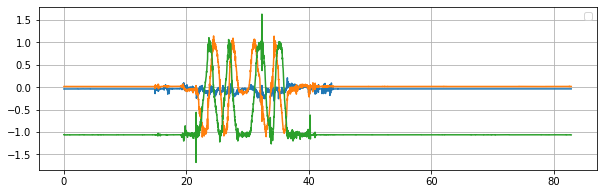

No handles with labels found to put in legend.


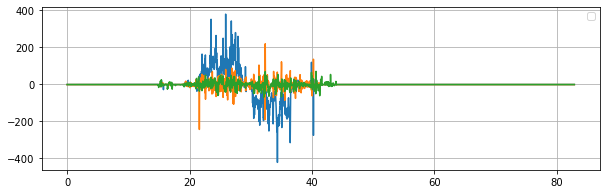

In [8]:
# View plot of data
figsize = (10, 3)


def plot(df, x, y, ax=None):
    """
    Plots the x and y selected from df
    
    Param:
        df: pd.DataFrame()
        x: str/int
        y: str[]/int[]
    """
    # Ensure y is iterable
    if type(y) != type([]):
        y = [y]
    
    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)
        
    for i in y:
        ax.plot(df[x], df[i])

    ax.legend()
    ax.grid()
    
    plt.show()
    
for v in d.values():
    plot(v['df'], 'elapsed', ['x', 'y', 'z'])

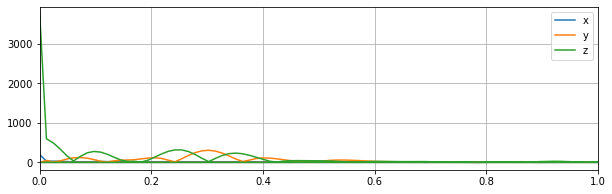

In [9]:
# View frequency of data
def plot_freq(df, y, fs=50, ax=None, xlim=None):
    """
    Plots the frequencies of the given columns
    
    Param:
        df: pd.DataFrame()
        y: int[]/str[]
            Columns to loop over to extract frequencies from
        fs: int
            Sampling rate
        ax: Axes
        xlim: int[]
            X Limits
    """
    # Ensure y is iterable
    if type(y) != type([]):
        y = [y]
        
    # Test for xlim
    if xlim:
        assert type(xlim) == type([])
        assert len(xlim) == 2
        for x in range(2):
            float(xlim[x])
    
    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)
        
    for i in y:
        # Perform FFT
        X = fftpack.fft(df[i].to_list())
        freq = fftpack.fftfreq(len(df[i])) * fs
        
        ax.plot(freq, np.abs(X), label=i)
        
    if xlim:
        ax.set_xlim(xlim)
        
    ax.legend()
    ax.grid()
    
    plt.show()
    
plot_freq(d['a']['df'], ['x', 'y', 'z'], xlim=[0, 1])

In [10]:
# We decide to cut it off at 0.6

In [11]:
# Low pass filter to eliminate noise
def lpf(data, fc, fs=50, order=4):
    """
    Low pass butterworth filter
    
    Param:
        data: int[]
            Signal to be cut off
        fc: float
            Cut off frequency
        fs: float
            Sampling frequency
            Default 50, based on Ken's util.py sampling of 50
        order: int
            Order of butterworth filter
    """
    # Arg check
    assert type(data) == type([])
    assert all(map(lambda x: type(float(x)) == type(float(1)), data))
    fc = float(fc)
    fs = float(fs)
    assert type(order) == type(int(1))
    
    # Normalize frequency
    w = fc / (fs / 2)
    
    # Low pass butterworth filter
    b, a = signal.butter(order, w, 'low')
    
    return signal.filtfilt(b, a, data)
    
for i in 'x y z'.split(' '):
    d['g']['df']['filtered_' + i] = lpf(d['g']['df'][i].to_list(), 0.6)

No handles with labels found to put in legend.


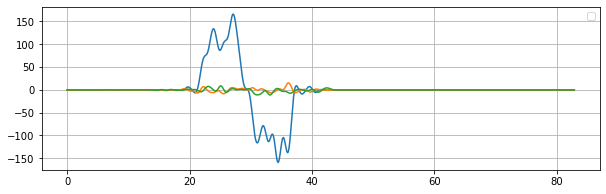

In [12]:
plot(d['g']['df'], 'elapsed', ['filtered_' + i for i in 'x y z'.split()])

In [13]:
# Not all data will match each other
# We want to ensure the data of accel and gyro match each other
# There is no exact 1-to-1 match
# Instead, we get the closest match


def match_df_shape(dfa, dfg):
    """
    Matches the number of rows of accel dataframe to gyro dataframe
    Allows for 1 extra value in gyroscope dataframe
    Extra row required to eliminate NaN row when calculating elapsed time difference
    
    Param:
        dfa, dfg: pd.DataFrame()
    
    Return:
        dfa, dfg: pd.DataFrame()
    """
    assert type(dfa) == type(pd.DataFrame())
    assert type(dfg) == type(pd.DataFrame())

    dfa = dfa.copy()
    dfg = dfg.copy()
    
    # If accel is one less than gyro, return
    if dfa.shape[0] == dfg.shape[0] - 1:
        return dfa, dfg
    else:
        # Ensure accel is at LEAST less than gyro, even if not by one
        assert dfa.shape[0] < dfg.shape[0], 'Unimplemented'
        
        # If so, we assume that the first index of accel is less than the first index of gyro for 'datetime'
        assert dfa['datetime'][0] > dfg['datetime'][0], 'Unimplemented'
        
        if dfa['datetime'][0] > dfg['datetime'][0]:
            diff = dfg['datetime'].apply(lambda x: abs(x - dfa['datetime'][0]))
            
            diff = diff[diff == diff.min()].index
            
            # Ensure only one index containing the closest match between accel and gyro
            assert len(diff) == 1
            
            diff = diff[0] - 1
            
            assert diff > 0
            
            dfg = dfg.loc[diff:, :].reset_index(drop=True)
            
            # Ensure accel and gyro are now differed by one
            assert dfa.shape[0] == dfg.shape[0] - 1
            
            if dfa.shape[0] == dfg.shape[0] - 1:
                return dfa, dfg


for i in ['a', 'g']:
    d[i]['df']['datetime'] = d[i]['df']['time'].apply(
        lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))

d['a']['df'], d['g']['df2'] = match_df_shape(d['a']['df'], d['g']['df'])

No handles with labels found to put in legend.


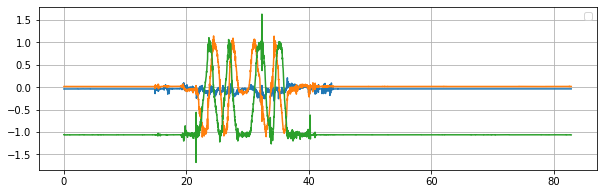

No handles with labels found to put in legend.


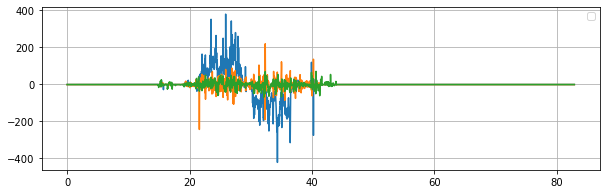

In [14]:
# Ensure data visualisation is still the same, i.e. no mistakes in trimming
plot(d['a']['df'], 'elapsed', ['x', 'y', 'z'])
plot(d['g']['df2'], 'elapsed', ['x', 'y', 'z'])

No handles with labels found to put in legend.


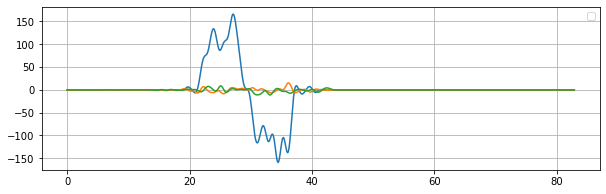

In [15]:
# Ensure data visualisation is still the same, i.e. no mistakes in trimming
plot(d['g']['df'], 'elapsed', ['filtered_' + i for i in ['x', 'y', 'z']])

In [16]:
# Get elapsed difference
d['g']['df2']['elapsed_diff'] = d['g']['df2']['elapsed'].diff()

# Pop first value
d['g']['df2'] = d['g']['df2'].loc[1:, :].reset_index(drop=True)

# Get degrees of rotation based on deg/s (x, y, z) multiplied by elapsed time
# Give the answer in radians
for i in ['filtered_' + i for i in ['x', 'y', 'z']]:
    d['g']['df2']['abs_' + i] = d['g']['df2'].apply(lambda x: math.radians(x['elapsed_diff'] * x[i] * -1), axis=1)
#     d['g']['df']['abs_' + i] = d['g']['df'].apply(lambda x: math.radians(x[i]), axis=1)
    
# Get rotation object
d['g']['df2']['R'] = d['g']['df2'].apply(lambda x: R.from_rotvec([x['abs_filtered_' + i] for i in ['x', 'y', 'z']]),axis=1)

In [17]:
d['g']['df2']

,epoch,time,elapsed,x,y,z,filtered_x,filtered_y,filtered_z,datetime,elapsed_diff,abs_filtered_x,abs_filtered_y,abs_filtered_z,R
0,1581425248972,2020-02-11T12:47:28.972,0.020,-0.198,-0.595,-0.716,-0.301984,-0.925260,-0.501762,2020-02-11 12:47:28.972,0.020,0.000105,0.000323,0.000175,(((<scipy.spatial.transform.rotation.Rotation ...
1,1581425248993,2020-02-11T12:47:28.993,0.041,-0.473,-0.640,-0.457,-0.310419,-0.914842,-0.498332,2020-02-11 12:47:28.993,0.021,0.000114,0.000335,0.000183,(((<scipy.spatial.transform.rotation.Rotation ...
2,1581425249013,2020-02-11T12:47:29.013,0.061,-0.488,-0.686,-0.473,-0.318776,-0.904483,-0.494917,2020-02-11 12:47:29.013,0.020,0.000111,0.000316,0.000173,(((<scipy.spatial.transform.rotation.Rotation ...
3,1581425249032,2020-02-11T12:47:29.032,0.080,-0.457,-0.747,-0.427,-0.327037,-0.894206,-0.491524,2020-02-11 12:47:29.032,0.019,0.000108,0.000297,0.000163,(((<scipy.spatial.transform.rotation.Rotation ...
4,1581425249053,2020-02-11T12:47:29.053,0.101,-0.473,-0.732,-0.412,-0.335183,-0.884033,-0.488159,2020-02-11 12:47:29.053,0.021,0.000123,0.000324,0.000179,(((<scipy.spatial.transform.rotation.Rotation ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,1581425331712,2020-02-11T12:48:51.712,82.760,-0.381,-0.732,-0.412,-0.454925,-0.721546,-0.430576,2020-02-11 12:48:51.712,0.019,0.000151,0.000239,0.000143,(((<scipy.spatial.transform.rotation.Rotation ...
4122,1581425331733,2020-02-11T12:48:51.733,82.781,-0.442,-0.701,-0.412,-0.454889,-0.721589,-0.430581,2020-02-11 12:48:51.733,0.021,0.000167,0.000264,0.000158,(((<scipy.spatial.transform.rotation.Rotation ...
4123,1581425331753,2020-02-11T12:48:51.753,82.801,-0.503,-0.701,-0.442,-0.454858,-0.721625,-0.430585,2020-02-11 12:48:51.753,0.020,0.000159,0.000252,0.000150,(((<scipy.spatial.transform.rotation.Rotation ...
4124,1581425331772,2020-02-11T12:48:51.772,82.820,-0.457,-0.701,-0.396,-0.454830,-0.721656,-0.430589,2020-02-11 12:48:51.772,0.019,0.000151,0.000239,0.000143,(((<scipy.spatial.transform.rotation.Rotation ...


No handles with labels found to put in legend.


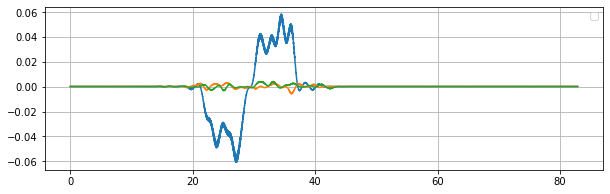

In [18]:
# Plot absolute rotation
plot(d['g']['df2'], 'elapsed', ['abs_filtered_' + i for i in ['x', 'y', 'z']])

In [19]:
# Apply rotation
# Extract xyz
xyz = d['a']['df'].apply(lambda x: [x[i] for i in ['x', 'y', 'z']], axis=1).to_list()

for i in tqdm(range(d['a']['df'].shape[0])):
    rotator = d['g']['df2'].loc[i, 'R']
    
    for j in range(i, d['a']['df'].shape[0]):        
        xyz[j] = rotator.apply(xyz[j], inverse=True)

In [20]:
# Add new xyz to accel df
xyz = pd.DataFrame(xyz, columns=['x', 'y', 'z'])

for i in ['x', 'y', 'z']:
    d['a']['df']['actual_' + i] = xyz[i]

In [21]:
d['a']['df']

,epoch,time,elapsed,x,y,z,datetime,actual_x,actual_y,actual_z
0,1581425248972,2020-02-11T12:47:28.972,0.000,-0.041,0.014,-1.059,2020-02-11 12:47:28.972,-0.040656,0.013896,-1.059015
1,1581425248993,2020-02-11T12:47:28.993,0.021,-0.041,0.014,-1.066,2020-02-11 12:47:28.993,-0.040293,0.013781,-1.066030
2,1581425249013,2020-02-11T12:47:29.013,0.041,-0.040,0.016,-1.063,2020-02-11 12:47:29.013,-0.038956,0.015670,-1.063044
3,1581425249032,2020-02-11T12:47:29.032,0.060,-0.041,0.016,-1.064,2020-02-11 12:47:29.032,-0.039637,0.015561,-1.064058
4,1581425249053,2020-02-11T12:47:29.053,0.081,-0.039,0.015,-1.065,2020-02-11 12:47:29.053,-0.037289,0.014435,-1.065069
...,...,...,...,...,...,...,...,...,...,...
4121,1581425331712,2020-02-11T12:48:51.712,82.740,-0.040,0.016,-1.063,2020-02-11 12:48:51.712,0.596741,-0.768186,-0.430832
4122,1581425331733,2020-02-11T12:48:51.733,82.761,-0.041,0.016,-1.065,2020-02-11 12:48:51.733,0.597476,-0.769673,-0.432190
4123,1581425331753,2020-02-11T12:48:51.753,82.781,-0.042,0.015,-1.063,2020-02-11 12:48:51.753,0.595223,-0.768854,-0.431892
4124,1581425331772,2020-02-11T12:48:51.772,82.800,-0.040,0.017,-1.063,2020-02-11 12:48:51.772,0.597448,-0.768004,-0.430214


No handles with labels found to put in legend.


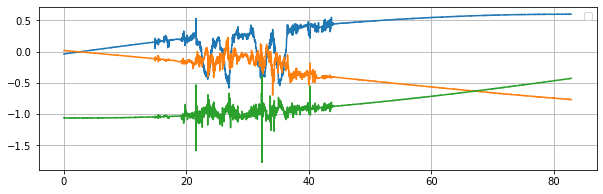

In [22]:
# Rotated signal
plot(d['a']['df'], 'elapsed', ['actual_' + i for i in ['x', 'y', 'z']])

No handles with labels found to put in legend.


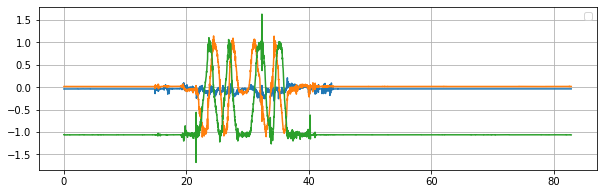

In [23]:
# Original signal
plot(d['a']['df'], 'elapsed', [i for i in ['x', 'y', 'z']])

No handles with labels found to put in legend.


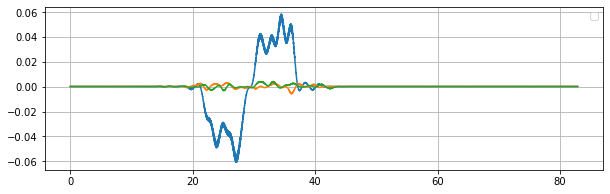

In [24]:
# Plot absolute rotation
plot(d['g']['df2'], 'elapsed', ['abs_filtered_' + i for i in ['x', 'y', 'z']])

In [25]:
# Remove gravitational offset
d['a']['df'].loc[:, 'actual_z'] = d['a']['df'].loc[:, 'actual_z'].apply(lambda x: x + 1)

No handles with labels found to put in legend.


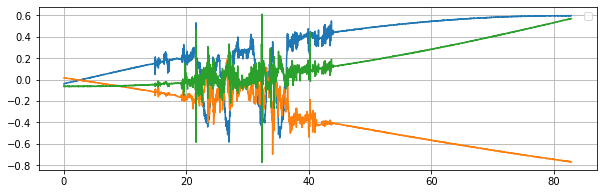

In [26]:
plot(d['a']['df'], 'elapsed', ['actual_' + i for i in ['x', 'y', 'z']])